# Ultra-fast categorization of image containing animals *in computo*

Hi! I am  [Jean-Nicolas Jérémie](https://github.com/JNJER) in this notebook, I will use the [Pytorch](https://pytorch.org/) library for running the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. This notebook focused on the training and the test of Deep convolutional neuronal networks (DCNNs) for ecological tasks such as detecting an animal in a natural scene.

Our coding strategy is to build up a small library as a package of scripts in the `src` folder and to run all calls to that library from this notebook. This notebook contains the scripts necessary to set the variables of the definition and the training of the networks (`init.py` & `model.py`). Thus this notebook allow the generation of dataset based on the [Imagenet database](https://www.image-net.org/) dedicates to a specific ecologic task (`dataset.py`). 

The set of labels of the Imagenet database is based on a large lexical database of English: [Wordnet](https://wordnet.princeton.edu/) . The nouns, verbs, adjectives, and adverbs in this database are grouped into a graphical set of cognitive synonyms (synset), each expressing a distinct concept. These synsets are linked between them by employing a small number of conceptual relations. I used the hyperonym link, for instance, a German shepherd is kind of a dog and a dog is a kind of an animal thus defining an hyperonym path. So the synset 'animal' is in the hyperonym path of the synset 'German sheperd'. Based on this relation, we selected a specific subset of labels in the Imagenet database to build our datasets.

This notebook was done during my thesis at the Neurosciences Institute of Timone (INT) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/). It is curated in the following [github repo](https://github.com/JNJER/2022-03_UltraFastCat).

In [1]:
%matplotlib inline
%mkdir -p src
%mkdir -p results
%mkdir -p models

## Initialization of the libraries/variables

First of all, a `src/init.py` to define all our usefull variables like the new labels to learn, the number of training images or the root. Also, we importe libraries to train the networks and display the results.

In [1]:
scriptname = 'src/init.py'

In [4]:
%%writefile {scriptname}

# Importing libraries
import torch
import argparse
import json
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
import numpy as np
from nltk.corpus import wordnet as wn
#from numpy import random
import os
import requests
import time

from time import strftime, gmtime
datetag = strftime("%Y-%m-%d", gmtime())

HOST, device = os.uname()[1], torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
# to store results
import pandas as pd

def arg_parse():
    #DEBUG = 25
    DEBUG = 1
    parser = argparse.ArgumentParser(description='DCNN_transfer_learning/init.py set root')
    parser.add_argument("--root", dest = 'root', help = "Directory containing images to perform the training",
                        default = '../data', type = str)
    parser.add_argument("--folders", dest = 'folders', help =  "Set the training, validation and testing folders relative to the root",
                        default = ['test', 'val', 'train'], type = list)
    parser.add_argument("--tasks", dest = 'tasks', help =  "Set the training, validation and testing folders relative to the root",
                        default = ['animal'], type = list)
    parser.add_argument("--goals", dest = 'goals', help =  "Set the training, validation and testing folders relative to the root",
                        default = ['target', 'distractor'], type = list)
    parser.add_argument("--N_images", dest = 'N_images', help ="Set the number of images per classe in the train folder",
                        default = [600//DEBUG, 400//DEBUG, 1000//DEBUG], type = list)
    parser.add_argument("--HOST", dest = 'HOST', help = "Set the name of your machine",
                    default=HOST, type = str)
    parser.add_argument("--datetag", dest = 'datetag', help = "Set the datetag of the result's file",
                    default = datetag, type = str)
    parser.add_argument("--image_size", dest = 'image_size', help = "Set the default image_size of the input",
                    default = 256)
    parser.add_argument("--image_sizes", dest = 'image_sizes', help = "Set the image_sizes of the input for experiment 2 (downscaling)",
                    default = [64, 128, 256, 512], type = list)
    parser.add_argument("--num_epochs", dest = 'num_epochs', help = "Set the number of epoch to perform during the traitransportationning phase",
                    default = 25//DEBUG)
    parser.add_argument("--batch_size", dest = 'batch_size', help="Set the batch size", default = 32)
    parser.add_argument("--lr", dest = 'lr', help="Set the learning rate", default = 0.0001)
    parser.add_argument("--momentum", dest = 'momentum', help="Set the momentum", default = 0.9)
    parser.add_argument("--beta2", dest = 'beta2', help="Set the second momentum - use zero for SGD", default = 0.)
    parser.add_argument("--url_loader", dest = 'url_loader', help = "Set the file containing imagenet urls",
                        default = 'Imagenet_urls_ILSVRC_2016.json', type = str)
    parser.add_argument("--model_path", dest = 'model_path', help = "Set the path to the pre-trained model",
                        default = 'models/re-trained_', type = str)
    parser.add_argument("--model_names", dest = 'model_names', help = "Modes for the new trained networks",
                        default = ['vgg16_gen', 'vgg16_scale', 'vgg16_gray', ], type = list)
    return parser.parse_args()

args = arg_parse()
datetag = args.datetag
json_fname = os.path.join('results', datetag + '_config_args.json')
load_parse = False # False to custom the config

if load_parse:
    with open(json_fname, 'rt') as f:
        print(f'file {json_fname} exists: LOADING')
        override = json.load(f)
        args.__dict__.update(override)
else:
    print(f'Creating file {json_fname}')
    with open(json_fname, 'wt') as f:
        json.dump(vars(args), f, indent=4)
    
# matplotlib parameters
colors = ['b', 'r', 'k', 'g', 'm', 'y']
fig_width = 20
phi = (np.sqrt(5)+1)/2 # golden ratio for the figures :-)

#to plot & display 
def pprint(message): #display function
    print('-'*len(message))
    print(message)
    print('-'*len(message))
    
#DCCN training
print('On date', args.datetag, ', Running benchmark on host', args.HOST, ' with device', device.type)

paths_task ={}
paths = {}
class_wnids = {}
N_images_per_class = {}
match = {}

for task in args.tasks :
    paths_task[task] = os.path.join(args.root, task) # data path
    os.makedirs(paths_task[task], exist_ok=True)
    paths[task] = {}
    match[task] = []
    for folder, N_image in zip(args.folders, args.N_images):
        paths[task][folder] = os.path.join(args.root, task, folder) # data path
        N_images_per_class[folder] = N_image
        os.makedirs(paths[task][folder], exist_ok=True)
        class_wnids[str(task)] = {}
        for goal in args.goals:
            class_wnids[str(task)][str(goal)] = []
    
with open(args.url_loader) as json_file:
    Imagenet_urls_ILSVRC_2016 = json.load(json_file)

# gathering labels
labels = []
reverse_id_labels = {}
for i_img, img_id in enumerate(Imagenet_urls_ILSVRC_2016):
    syn_= wn.synset_from_pos_and_offset('n', int(img_id.replace('n','')))
    reverse_id_labels[img_id] = syn_.lemmas()[0].name()
    labels.append(syn_.lemmas()[0].name())
    sem_ = syn_.hypernym_paths()[0]
    for task in args.tasks :
        for i in np.arange(len(sem_)):
            if sem_[i].lemmas()[0].name() == str(task) :
                class_wnids[str(task)]['target'].append(img_id)
                match[task].append(i_img)
        if img_id not in class_wnids[str(task)]['target']:
            class_wnids[str(task)]['distractor'].append(img_id)

        
# a reverse look-up-table giving the index of a given label (within the whole set of imagenet labels)
reverse_labels = {}
for i_label, label in enumerate(labels):
    reverse_labels[label] = i_label

# a reverse look-up-table giving the label of a given index in the last layer of the new model (within the sub-set of classes)
reverse_model_labels = args.tasks
reverse_model_labels.sort()

pprint('List of Pre-selected tasks : ')
# choosing the selected classes for recognition
for task in args.tasks :
    print(len(class_wnids[str(task)]['target']), ' Targets for the task :', task)
    print(len(class_wnids[str(task)]['distractor']), ' Distractors for the task :', task)

Overwriting src/init.py


In [5]:
%run src/init.py

Creating file results/2022-05-08_config_args.json
On date 2022-05-08 , Running benchmark on host neo-ope-de04  with device cuda
-----------------------------
List of Pre-selected tasks : 
-----------------------------
398  Targets for the task : animal
602  Distractors for the task : animal


## Download the `train` & `val` dataset

In the dataset.py, we use an archive of the Imagenet fall 2011 urls to populate datasets based on the pre-selected synsets listed in the `src/init.py` file.

In [4]:
scriptname = 'src/dataset.py'

In [5]:
%%writefile {scriptname}

from src.init import *  
verbose = False

with open(args.url_loader) as json_file:
    Imagenet_urls_ILSVRC_2016 = json.load(json_file)

def clean_list(list_dir, patterns=['.DS_Store']):
    for pattern in patterns:
        if pattern in list_dir: list_dir.remove('.DS_Store')
    return list_dir

import imageio
def get_image(img_url, timeout=3., min_content=3, verbose=verbose):
    try:
        img_resp = imageio.imread(img_url)
        if (len(img_resp.shape) < min_content): # TODO : raise error when min_content is not reached
            if verbose : print(f"Url {img_url} does not have enough content")
            return False
        else:
            if verbose : print(f"Success with url {img_url}")
            return img_resp
    except Exception as e:
        if verbose : print(f"Failed with {e} for url {img_url}")
        return False # did not work

import hashlib # jah.

# train, val and test folders
    
list_urls = {}
list_img_name_used = {}
for task in class_wnids :
    list_urls[task] = {}
    list_img_name_used[task] = {}
    for goal in class_wnids[task]:
        list_urls[task][goal] = {}
        for class_wnid in class_wnids[task][goal]:
            list_urls[task][goal][class_wnid] = Imagenet_urls_ILSVRC_2016[str(class_wnid)]
        np.random.shuffle(list_urls[task][goal][class_wnid])
        list_img_name_used[task][goal] = []
            
    
# train, val and test folders
for task in args.tasks:
    pprint(f'Task \"{task}\"')
    for folder in args.folders :
        print(f'Folder \"{folder}\"')
        filename = f'results/{datetag}_dataset_{folder}_{args.HOST}.json'
        columns = ['task', 'goal', 'img_url', 'img_name', 'is_flickr', 'dt', 'worked', 'class_wnid', 'class_name']
        if os.path.isfile(filename):
            df_dataset = pd.read_json(filename)
        else:
            df_dataset = pd.DataFrame([], columns=columns)
        for goal in args.goals :
            print(f'Scraping images for task \"{task}\" : {goal} ')
            task_goal_folder = os.path.join(paths[task][folder], goal)
            os.makedirs(task_goal_folder, exist_ok=True)
            list_img_name_used[task][goal] += clean_list(os.listdir(os.path.join(paths[task][folder], goal))) # join two lists
            while (len(clean_list(os.listdir(task_goal_folder))) < N_images_per_class[folder]):
                class_wnid = np.random.choice(class_wnids[task][goal], 1)[0]
                pos = class_wnids[task][goal].index(class_wnid)
                class_name = reverse_id_labels[class_wnid]
                # pick and remove element from shuffled list
                if len(list_urls[task][goal][class_wnid])==0:
                    del class_wnids[task][goal][pos], list_urls[task][goal][class_wnid]
                else:
                    img_url = list_urls[task][goal][class_wnid].pop()

                    if len(df_dataset[df_dataset['img_url']==img_url])==0 : # we have not yet tested this URL yet

                        # Transform URL into filename
                        # https://laurentperrinet.github.io/sciblog/posts/2018-06-13-generating-an-unique-seed-for-a-given-filename.html
                        img_name = hashlib.sha224(img_url.encode('utf-8')).hexdigest() + '.png'

                        if img_url.split('.')[-1] in ['.tiff', '.bmp', 'jpe', 'gif']:
                            if verbose: print('Bad extension for the img_url', img_url)
                            worked, dt = False, 0.
                        # make sure it was not used in other folders
                        elif not (img_name in list_img_name_used[task][goal]):
                            tic = time.time()
                            img_content = get_image(img_url, verbose=verbose)
                            dt = time.time() - tic
                            worked = img_content is not False
                            if worked:
                                if verbose : print('Good URl, now saving', img_url, ' in', task_goal_folder, ' as', img_name)
                                imageio.imsave(os.path.join(task_goal_folder, img_name), img_content, format='png')
                                list_img_name_used[task][goal].append(img_name)
                        df_dataset.loc[len(df_dataset.index)] = {'task': task, 'goal': goal, 'img_url':img_url, 'img_name':img_name, 'is_flickr':1 if 'flickr' in img_url else 0, 'dt':dt,
                                        'worked':worked, 'class_wnid':class_wnid, 'class_name':class_name}
                        df_dataset.to_json(filename)
                        print(f'\r{len(clean_list(os.listdir(task_goal_folder)))} / {N_images_per_class[folder]}', end='\n' if verbose else '', flush=not verbose)

        if (len(clean_list(os.listdir(task_goal_folder))) < N_images_per_class[folder]) and (len(list_urls[task][goal]) == 0): 
            print('Not enough working url to complete the dataset') 

    df_dataset.to_json(filename)

print('\n')
pprint(f'Some random images :')
import imageio
N_image_i = 4
image_plot_paths = {}
task_folder = {}
x = 0
folder = 'train'
fig, axs = plt.subplots(len(args.tasks)*len(args.goals), N_image_i, figsize=(fig_width, fig_width))
for task in args.tasks:
    for goal in args.goals:
        task_goal_folder = os.path.join(paths[task][folder], goal)
        image_plot_paths = os.listdir(task_goal_folder)
        for i_image in np.arange(N_image_i):
            ax = axs[x][i_image]
            path = os.path.join(task_goal_folder, image_plot_paths[i_image])
            ax.imshow(imageio.imread(path))
            ax.set_xticks([])
            ax.set_yticks([])  
            if i_image%5 == 0:
                ax.set_ylabel((task+' '+goal), fontsize = 18)
        x +=1
fig.set_facecolor(color='white')

Overwriting src/dataset.py


Creating file results/2022-02-22_config_args.json
On date 2022-02-22 , Running benchmark on host neo-ope-de04  with device cuda
-----------------------------
List of Pre-selected tasks : 
-----------------------------
398  Targets for the task : animal
602  Distractors for the task : animal
522  Targets for the task : artifact
478  Distractors for the task : artifact
-------------
Task "animal"
-------------
Folder "test"
Scraping images for task "animal" : target 
Scraping images for task "animal" : distractor 
Folder "val"
Scraping images for task "animal" : target 
Scraping images for task "animal" : distractor 
Folder "train"
Scraping images for task "animal" : target 
Scraping images for task "animal" : distractor 
---------------
Task "artifact"
---------------
Folder "test"
Scraping images for task "artifact" : target 
Scraping images for task "artifact" : distractor 
Folder "val"
Scraping images for task "artifact" : target 
Scraping images for task "artifact" : distractor 
Fol

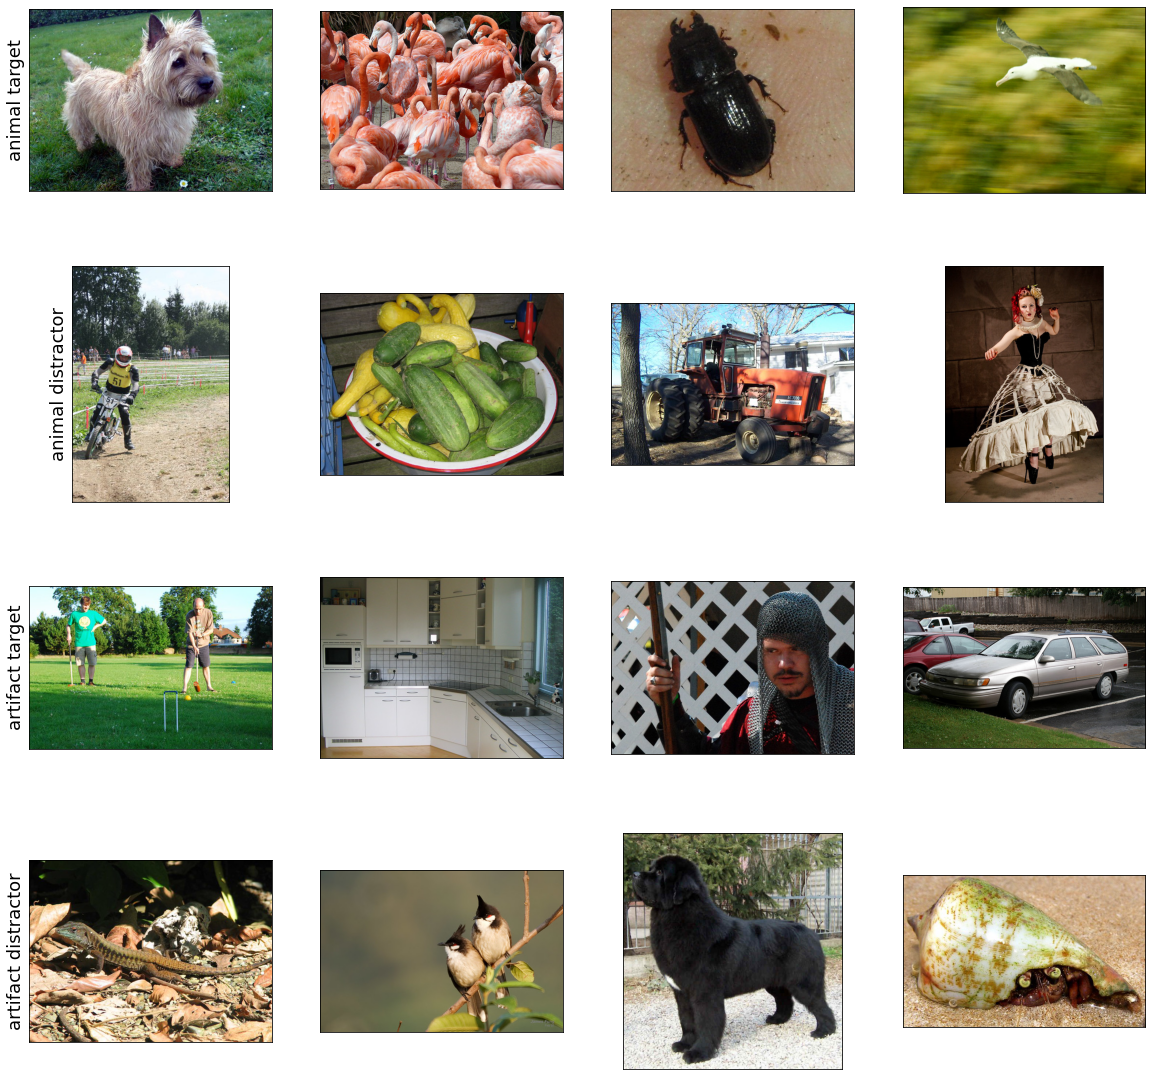

In [6]:
%run {scriptname}

## Transfer learning and dataset config

On the model.py we first define the `transforme`functions for the datasets. To perform image augmentation we apply the Pytorch `AutoAugment` function to the `train` and `val` dataset. I also add a grayscale, shuffle and resize function in order to test different training strategies and test the networks on various conditions.  

In [1]:
scriptname = 'src/model.py'

In [11]:
%%writefile {scriptname}

from src.init import *  

import torch
import torch.nn.functional as nnf
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn

class ShufflePatches(object): #https://stackoverflow.com/questions/66962837/shuffle-patches-in-image-batch
    def __init__(self, patch_size):
        self.ps = patch_size

    def __call__(self, x):
        # divide the batch of images into non-overlapping patches
        u = nnf.unfold(x.unsqueeze(dim=0), kernel_size=self.ps, stride=self.ps, padding=0)
        # permute the patches of each image in the batch
        pu = torch.cat([b_[:, torch.randperm(b_.shape[-1])][None,...] for b_ in u], dim=0)
        # fold the permuted patches back together
        f = nnf.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
        return f.squeeze(dim=0)

# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=mean, std=std) # to normalize colors on the imagenet dataset

import seaborn as sns
import sklearn.metrics
from scipy import stats
from scipy.special import logit, expit

image_datasets = {}
dataloaders = {}
dataset_sizes = {}

# VGG-16 datasets initialisation
def datasets_transforms(image_size=args.image_size, p=0, shuffle=args.image_size , num_workers=1, angle=0, batch_size=args.batch_size, **kwargs):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),

        'val': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.AutoAugment(), 
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),    
            transforms_norm ]),

        'test': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),
            transforms_norm, 
            ShufflePatches(patch_size=(shuffle,shuffle)) ]), # our new transform to shuffle patches of images
    }
    
    for task in args.tasks:
        image_datasets[task] = {
            folder: datasets.ImageFolder(
                paths[task][folder], 
                transform=data_transforms[folder]
            )
            for folder in args.folders
        }

        dataloaders[task] = {
            folder: torch.utils.data.DataLoader(
                image_datasets[task][folder], batch_size=batch_size,
                shuffle=True if folder == "train" else False, num_workers=num_workers
            )
            for folder in args.folders
        }

        dataset_sizes[task] = {folder: len(image_datasets[task][folder]) for folder in args.folders}

    return dataset_sizes, dataloaders, image_datasets, data_transforms

(dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size)

for task in args.tasks :
    pprint(task)
    for folder in args.folders : print(f"Loaded {dataset_sizes[task][folder]} images under {folder}")

Overwriting src/model.py


In [3]:
%run {scriptname}

Creating file results/2022-05-09_config_args.json
On date 2022-05-09 , Running benchmark on host neo-ope-de04  with device cuda
-----------------------------
List of Pre-selected tasks : 
-----------------------------
398  Targets for the task : animal
602  Distractors for the task : animal
------
animal
------
Loaded 1201 images under test
Loaded 800 images under val
Loaded 2000 images under train
